Load packages and some data from the server

In [1]:
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn
import scipy
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance
import re

In [2]:
basepath = '/Users/B246357/ssi_stuff/for_michele/'
#metadata_clean = pd.read_excel(basepath + 'metadata_clean.xlsx', engine='calamine')

In [3]:
persistent_bacteremia = pd.read_csv(basepath + 'df.Rtab', sep = '\t')
persistent_bacteremia['sex_binary'] = [1 if i == 'Male' else 0 for i in persistent_bacteremia['Sex'].to_list()]
persistent_bacteremia.rename(columns={'Persistant_bacteremia':'persistent_bacteremia'}, inplace=True)
#mortality_30_day = pd.read_csv(basepath + 'Set_28day_mortality_palliative_decision/df.Rtab', sep = '\t')
#mortality_30_day['sex_binary'] = [1 if i == 'Male' else 0 for i in mortality_30_day['Sex'].to_list()]

The classes are unbalanced which means we will need to take this into account when evaluating metrics

In [4]:
persistent_bacteremia_gwas_results = pd.read_excel(basepath + 'gene_treewas.xlsx')
#mortality_30_day_gwas_results = pd.read_excel(basepath + 'gene_treewas.xlsx')

In [5]:
print(persistent_bacteremia_gwas_results.shape)
#print(mortality_30_day_gwas_results.shape)
#print(metadata_clean.shape)
#mortality_30_day.columns.to_list()
print(persistent_bacteremia.shape)
#print(mortality_30_day.shape)

(8404, 21)
(303, 106)


In [6]:
gene_absence_presence_matrix = pd.read_csv(basepath + 'gene_presence_absence.Rtab', sep = '\t')

The matrix is in gene x sample with the first column being name of genes, we will transpose it and add genes as column names.

In [7]:
genes = gene_absence_presence_matrix.Gene
values = gene_absence_presence_matrix.iloc[0:, gene_absence_presence_matrix.columns != 'Gene'] # iloc can both be used with numerical and boolean indexing
gene_matrix = values.T
gene_matrix.columns = genes
#gene_matrix.rename(index={'SSAB19166_1':'SSAB19166'}, inplace=True)


In [8]:
def generate_joined_matrix(gwas_metadata: pd.DataFrame, gwas_results: pd.DataFrame, gene_sample_matrix: pd.DataFrame, x_variables: list, y: str):
    # subset the full sample x gene presence absence matrix for the samples in the metadatada of the understudy
    samples_in_gene_matrix = gene_sample_matrix.loc[np.isin(gene_sample_matrix.index, gwas_metadata.sample_name)].copy()
    # obtain genes that were significant from the treewas results
    significant_rows = gwas_results[['terminal_pvalue', 'simultaneous_pvalue', 'subsequent_pvalue']] <= 0.05/gwas_results.shape[0]
    significant_rows_bool = np.any(significant_rows.to_numpy(), axis=1)
    significant_df = gwas_results.loc[significant_rows_bool, :]
    samples_in_gene_matrix.rename(index={'SSAB19166_1':'SSAB19166'}, inplace=True) # rename this annoying sample so we can join with the metadata
    significant_matrix = samples_in_gene_matrix.loc[:, np.isin(samples_in_gene_matrix.columns, significant_df.ID)] # sample x significant gene matrix
    # subset the metadata with the chosen variables
    variable_list = [y] + x_variables
    metadata_variable_subset = gwas_metadata[variable_list]
    metadata_variable_subset.set_index('original_sample_name', inplace=True)
    joined_data_frame = metadata_variable_subset.join(significant_matrix) # joins on index by default
    return joined_data_frame


In [9]:
persistent_bacteremia.drop(['Sex', 'Sex_binary'], axis=1)

,original_sample_name,Date_string,Age,Comorbidity_uCCI,Community_aquired,Nosocomial,Health_care_associated,Include_for_persistant_bacteremia_analysis,persistent_bacteremia,Infectios_focus_Endocarditis_1=yes_0=no,...,called_snp....,called_degen,called_degen....,quality_breadth_z,failed_coverage_filter_z,failed_proportion_filter_z,NASP_QC_pass,study_include,MLST2,sex_binary
0,SSAB18003,180902,98,5,1,0,0,1,1,0,...,1.71%,284605,9.98%,-0.67,-0.04,0.49,True,True,15,0
1,SSAB18012,180305,94,6,0,0,1,1,0,0,...,1.46%,267757,9.39%,-0.51,0.05,-0.16,True,True,Other ST,1
2,SSAB18014,180907,93,2,1,0,0,1,1,0,...,0.05%,140767,4.94%,1.24,-0.19,-1.21,True,True,45,1
3,SSAB18022,180926,91,0,0,1,0,1,0,0,...,0.06%,128171,4.50%,1.42,-0.22,-1.88,True,True,45,1
4,SSAB18024,180607,90,4,1,0,0,1,0,0,...,1.70%,297684,10.44%,-0.92,0.13,-0.32,True,True,Other ST,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,TSAB19120,190326,70,0,0,0,1,1,1,0,...,1.72%,304686,10.69%,-1.19,0.43,1.13,True,True,-,1
299,TSAB19121,191111,47,1,0,0,1,1,0,0,...,1.70%,320955,11.26%,-1.30,0.27,0.83,True,True,-,0
300,TSAB19125,190529,67,0,1,0,0,1,0,0,...,1.74%,261360,9.17%,-0.48,0.16,0.81,True,True,7,0
301,TSAB19128,191223,89,6,0,0,1,1,1,0,...,1.47%,214966,7.54%,0.23,-0.07,0.36,True,True,30,0


In [10]:
persistent_bacteremia['persistent_bacteremia']

0      1
1      0
2      1
3      0
4      0
      ..
298    1
299    0
300    0
301    1
302    1
Name: persistent_bacteremia, Length: 303, dtype: int64

generate a random matrix

In [11]:
random_bernoulli = np.random.binomial(n=1, p=0.5, size=(306,10000))

In [12]:
random_bernoulli.shape

(306, 10000)

In [13]:
#x_var = ['original_sample_name', 'sex_binary', 'Age', 'Comorbidity_uCCI', 'Community_aquired', 'Nosocomial','Health_care_associated']
x_var = persistent_bacteremia.drop(['Sex', 'Sex_binary', 'study_include', 'Date_string', 'persistent_bacteremia', 'Assembly_QC_pass', 'NASP_QC_pass'], axis=1).columns.tolist()
joined_bacteremia = generate_joined_matrix(persistent_bacteremia, persistent_bacteremia_gwas_results, gene_matrix, x_var, 'persistent_bacteremia')
joined_bacteremia.drop(joined_bacteremia.select_dtypes(include='object').columns, inplace=True, axis=1)
joined_bacteremia.dropna(axis=1, how='any', inplace=True)
#joined_mortality = generate_joined_matrix(mortality_30_day, mortality_30_day_gwas_results, gene_matrix, x_var, 'Deceased_within_28days')
#print(joined_test.head())

In [14]:
#drop more columns
qc = [i for i in joined_bacteremia.columns if re.search('bp|filter|50|90|quality|breadth|length|reference|called|contig|study|analysis', i)]
print(qc)
joined_bacteremia.drop(qc, axis=1, inplace=True)
print(joined_bacteremia.shape)

['Include_for_persistant_bacteremia_analysis', 'study3', 'X..contigs.....0.bp.', 'X..contigs.....1000.bp.', 'X..contigs.....5000.bp.', 'X..contigs.....10000.bp.', 'X..contigs.....25000.bp.', 'X..contigs.....50000.bp.', 'Total.length.....0.bp.', 'Total.length.....1000.bp.', 'Total.length.....5000.bp.', 'Total.length.....10000.bp.', 'Total.length.....25000.bp.', 'Total.length.....50000.bp.', 'X..contigs', 'Largest.contig', 'Total.length', 'N50', 'N90', 'L50', 'L90', 'X..N.s.per.100.kbp', 'was_called', 'failed_coverage_filter', 'failed_proportion_filter', 'reference_length', 'Quality_breadth', 'called_reference', 'called_snp', 'called_degen', 'quality_breadth_z', 'failed_coverage_filter_z', 'failed_proportion_filter_z', 'group_3900', 'group_5085']
(303, 29)


In [15]:
#significant_mortality_bool = mortality_30_day_gwas_results[['terminal_pvalue', 'simultaneous_pvalue', 'subsequent_pvalue']] == 0
#significant_mortality_bool_1d = np.any(significant_mortality_bool.to_numpy(), axis=1)
#significant_mortality_df = mortality_30_day_gwas_results.loc[significant_mortality_bool_1d, :]
#print(significant_mortality_df.shape)
#print(significant_mortality_df.head())

Split the data into 80% training and 20% testing. We since there's a class imbalance we also make sure we aren't underselecting the positive class (persistent bacteremia) in our test set

In [16]:
print(persistent_bacteremia.persistent_bacteremia.value_counts()/persistent_bacteremia.persistent_bacteremia.shape[0])
#print(mortality_30_day.Deceased_within_28days.value_counts()/mortality_30_day.Deceased_within_28days.shape[0])

persistent_bacteremia
0    0.640264
1    0.359736
Name: count, dtype: float64


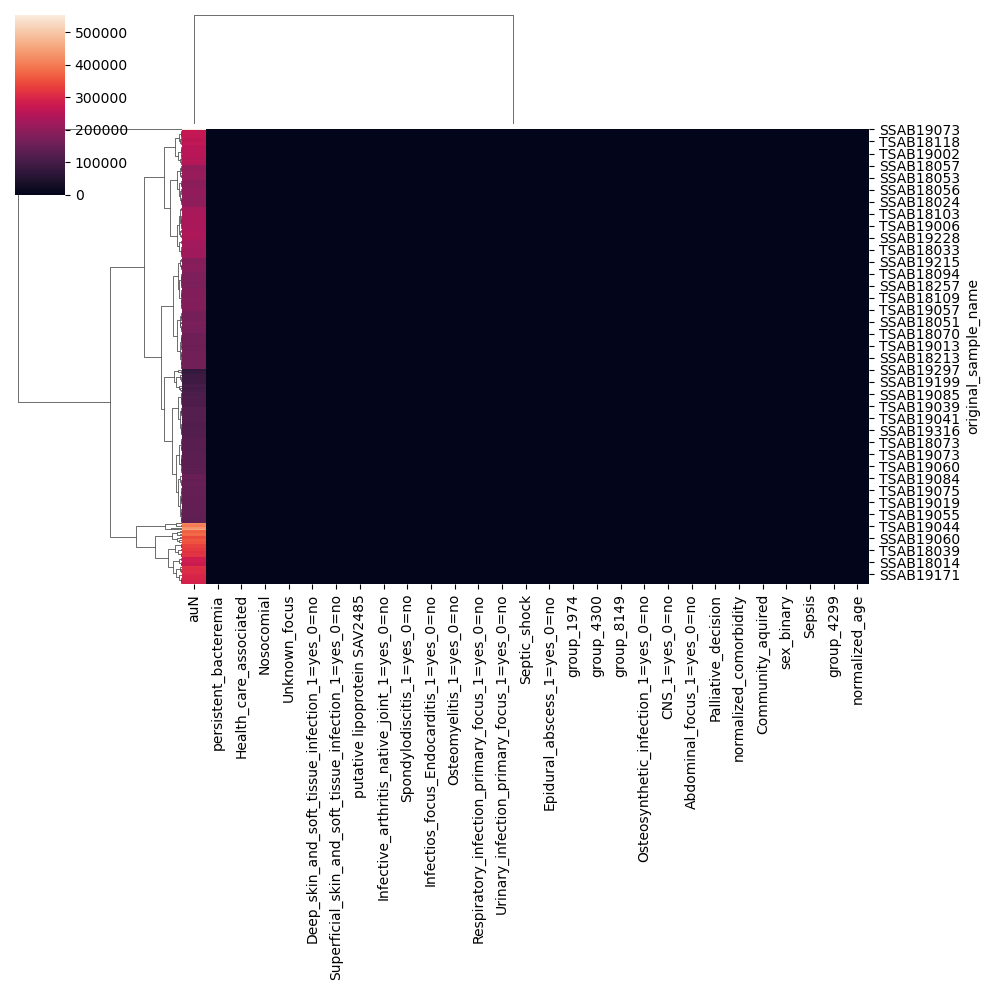

In [17]:
heatmap_df = joined_bacteremia.copy()
heatmap_df['normalized_age'] = heatmap_df.Age/max(heatmap_df.Age)
heatmap_df['normalized_comorbidity'] = heatmap_df.Comorbidity_uCCI/max(heatmap_df.Comorbidity_uCCI)
#seaborn.heatmap(heatmap_df.drop('Age', axis=1), vmin = 0, vmax = 1)
seaborn.clustermap(heatmap_df.drop(['Age', 'Comorbidity_uCCI'], axis=1))
#seaborn.clustermap(heatmap_df[['persistent_bacteremia', 'Comorbidity_uCCI']])

In [18]:
#heatmap_df.dtypes.value_counts()
#joined_bacteremia.select_dtypes(include='object').columns
#heatmap_df
#joined_bacteremia.select_dtypes(include='float64')
heatmap_df

,persistent_bacteremia,Age,Comorbidity_uCCI,Community_aquired,Nosocomial,Health_care_associated,Infectios_focus_Endocarditis_1=yes_0=no,Respiratory_infection_primary_focus_1=yes_0=no,Infective_arthritis_native_joint_1=yes_0=no,Osteosynthetic_infection_1=yes_0=no,...,Septic_shock,auN,sex_binary,group_4299,putative lipoprotein SAV2485,group_4300,group_1974,group_8149,normalized_age,normalized_comorbidity
original_sample_name,,,,,,,,,,,,,,,,,,,,,
SSAB18003,1,98,5,1,0,0,0,0,0,0,...,0,165380.0,0,1,0,0,0,0,0.989899,0.555556
SSAB18012,0,94,6,0,0,1,0,1,0,0,...,0,136571.1,1,1,0,0,0,0,0.949495,0.666667
SSAB18014,1,93,2,1,0,0,0,0,1,0,...,0,276940.5,1,0,0,1,0,0,0.939394,0.222222
SSAB18022,0,91,0,0,1,0,0,0,0,0,...,0,352976.7,1,1,0,0,0,0,0.919192,0.000000
SSAB18024,0,90,4,1,0,0,0,0,0,0,...,0,199526.5,0,1,0,0,0,0,0.909091,0.444444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TSAB19120,1,70,0,0,0,1,0,0,0,0,...,0,122745.1,1,1,0,0,0,0,0.707071,0.000000
TSAB19121,0,47,1,0,0,1,0,0,0,0,...,0,146609.4,0,1,0,0,0,0,0.474747,0.111111
TSAB19125,0,67,0,1,0,0,0,1,0,0,...,0,148578.1,0,1,0,0,0,0,0.676768,0.000000


<Axes: >

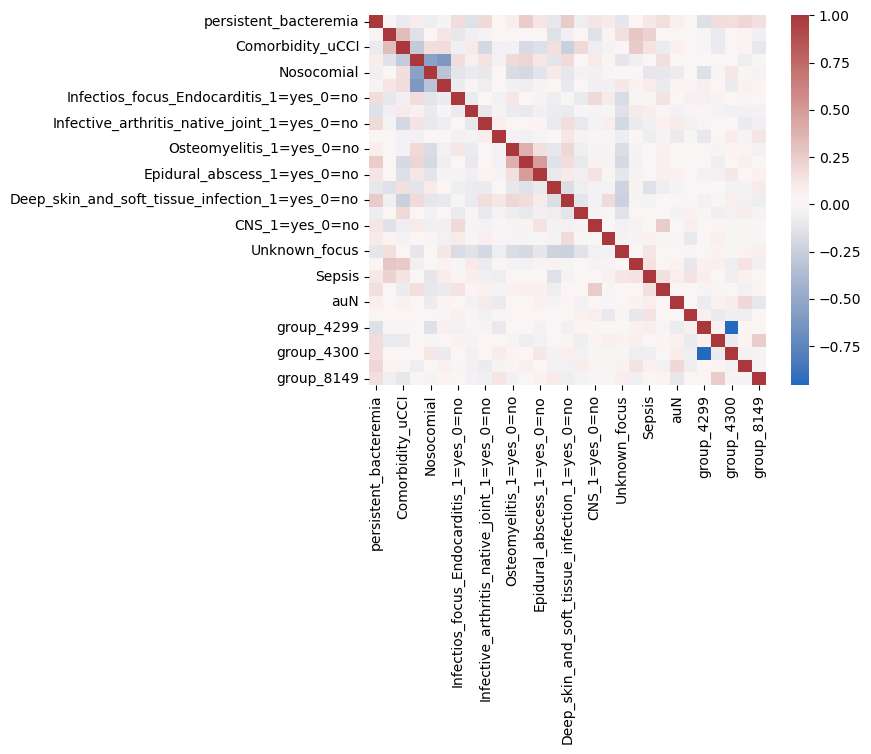

In [19]:
heatmap_df_corr = heatmap_df.drop(['normalized_age', 'normalized_comorbidity'], axis=1).corr() # dropping nomralized columns doesnt change the result as it's just scalar multiplication but for easier reading of names
seaborn.heatmap(heatmap_df_corr, cmap='vlag')

In [20]:
random_state = 666
np.random.seed(random_state) # for reproduction

In [21]:
def generate_stratified_split(df: pd.DataFrame, target_str: str) -> dict:
    test_frac = 0.2
    test_dfs = {}
    train_dfs = {}
    classes = np.unique(df[target_str])
    for i in classes:
        sub_df = df.loc[df[target_str] == i, :]
        n_sub = sub_df.shape[0]
        sub_indices_shuffled = np.random.choice(a = np.arange(n_sub), size = n_sub, replace = False)
        n_test = np.intc(np.ceil(n_sub*test_frac))
        test_idx = sub_indices_shuffled[0:n_test]
        train_idx = sub_indices_shuffled[n_test:]
        test_dfs[i] = sub_df.iloc[test_idx, :]
        train_dfs[i] = sub_df.iloc[train_idx, :]
    train_df_conc = pd.concat([train_dfs[i] for i in train_dfs.keys()])
    test_df_conc = pd.concat([test_dfs[i] for i in test_dfs.keys()])
    return {'train': train_df_conc, 'test': test_df_conc}


In [22]:
#train_df_conc = pd.concat([train_dfs[i] for i in train_dfs.keys()])
#test_df_conc = pd.concat([test_dfs[i] for i in test_dfs.keys()])


In [23]:
split_dicts = generate_stratified_split(joined_bacteremia, 'persistent_bacteremia')
train_df_conc, test_df_conc = split_dicts['train'], split_dicts['test']

sanity_check = pd.concat([train_df_conc, test_df_conc])
sanity_check.sort_index().equals(joined_bacteremia)


True

In [24]:
train_df_conc.columns

Index(['persistent_bacteremia', 'Age', 'Comorbidity_uCCI', 'Community_aquired',
       'Nosocomial', 'Health_care_associated',
       'Infectios_focus_Endocarditis_1=yes_0=no',
       'Respiratory_infection_primary_focus_1=yes_0=no',
       'Infective_arthritis_native_joint_1=yes_0=no',
       'Osteosynthetic_infection_1=yes_0=no', 'Osteomyelitis_1=yes_0=no',
       'Spondylodiscitis_1=yes_0=no', 'Epidural_abscess_1=yes_0=no',
       'Superficial_skin_and_soft_tissue_infection_1=yes_0=no',
       'Deep_skin_and_soft_tissue_infection_1=yes_0=no',
       'Urinary_infection_primary_focus_1=yes_0=no', 'CNS_1=yes_0=no',
       'Abdominal_focus_1=yes_0=no', 'Unknown_focus', 'Palliative_decision',
       'Sepsis', 'Septic_shock', 'auN', 'sex_binary', 'group_4299',
       'putative lipoprotein SAV2485', 'group_4300', 'group_1974',
       'group_8149'],
      dtype='object')

In [25]:
trainx = train_df_conc.loc[:, train_df_conc.columns != 'persistent_bacteremia'].to_numpy()
trainy = train_df_conc.loc[:, train_df_conc.columns == 'persistent_bacteremia'].to_numpy().ravel()

testx = test_df_conc.loc[:, test_df_conc.columns != 'persistent_bacteremia'].to_numpy()
testy = test_df_conc.loc[:, test_df_conc.columns == 'persistent_bacteremia'].to_numpy().ravel()
test_model = sklearn.ensemble.RandomForestClassifier(n_estimators = 1000, class_weight='balanced')
test_model.fit(trainx, trainy)

RandomForestClassifier(class_weight='balanced', n_estimators=1000)

In [26]:
def return_sklearn_metrics(fitted_predictor_instance, x, y):
    predicted_y = fitted_predictor_instance.predict(x)
    probs_y = fitted_predictor_instance.predict_proba(x)[:, 1]
    metrics = {'accuracy':accuracy_score(y, predicted_y),
               'balanced_accuracy':balanced_accuracy_score(y, predicted_y),
               'recall':recall_score(y, predicted_y),
               'precision':precision_score(y, predicted_y),
               'f1_macro':f1_score(y, predicted_y, average='macro'),
               'roc_auc':roc_auc_score(y, probs_y),
               'mcc':matthews_corrcoef(y, predicted_y)}
    return metrics

In [27]:
predicted_train = test_model.predict(trainx)
predicted_test = test_model.predict(testx)

In [28]:
print(return_sklearn_metrics(test_model, trainx, trainy))
print(return_sklearn_metrics(test_model, testx, testy))


{'accuracy': 1.0, 'balanced_accuracy': 1.0, 'recall': 1.0, 'precision': 1.0, 'f1_macro': 1.0, 'roc_auc': 1.0, 'mcc': 1.0}
{'accuracy': 0.6229508196721312, 'balanced_accuracy': 0.5664335664335665, 'recall': 0.36363636363636365, 'precision': 0.47058823529411764, 'f1_macro': 0.5665739882607352, 'roc_auc': 0.7115384615384616, 'mcc': 0.14230180488055505}


In [29]:
print(f1_score(trainy, predicted_train, average='binary'))
print(f1_score(trainy, predicted_train, average='micro'))
print(f1_score(trainy, predicted_train, average='macro'))
print(sklearn.metrics.precision_score(trainy, predicted_train))
print(sklearn.metrics.recall_score(trainy, predicted_train))
#print(sklearn.metrics.recall_score(testy, predicted_test))

1.0
1.0
1.0
1.0
1.0


In [30]:
recall = np.logical_and(trainy == 1, predicted_train == 1).sum()/trainy[trainy==1].shape[0]
precision = np.logical_and(trainy == 1, predicted_train == 1).sum()/predicted_train[predicted_train==1].shape[0]
f1_test = 2*precision*recall/(precision+recall)
true_positives = np.logical_and(trainy == 1, predicted_train == 1).sum()
false_positives = np.logical_and(trainy == 0, predicted_train == 1).sum()
false_negatives = np.logical_and(trainy == 1, predicted_train == 0).sum()
f1_test2 = 2*true_positives/(2*true_positives + false_positives + false_negatives)
print(recall, precision, f1_test, f1_test2)

1.0 1.0 1.0 1.0


In [31]:
cv_test = sklearn.model_selection.cross_val_score(test_model, trainx, trainy, scoring='f1_macro')
cv_test

array([0.65      , 0.7030303 , 0.68351648, 0.48619718, 0.61111111])

In [32]:
rf_params = {'criterion': ['gini', 'entropy', 'log_loss'],
             'min_samples_split': [2, 5, 10],
             'min_samples_leaf': [1, 2, 4],
            'n_estimators':[50, 100, 200],
            'max_depth':[2, 3, 10]}

grid = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=666),
                    rf_params,
                    scoring={'f1':'f1_macro','mcc':'matthews_corrcoef'}, 
                    cv=5,
                    refit='f1', 
                    n_jobs=8)

In [33]:
grid.fit(trainx, trainy)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=666),
             n_jobs=8,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [2, 3, 10], 'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             refit='f1',
             scoring={'f1': 'f1_macro', 'mcc': 'matthews_corrcoef'})

In [36]:
pd.DataFrame(grid.cv_results_).shape

(243, 26)

In [219]:
print(grid.best_score_)
print(grid.best_params_)
cv_grid = sklearn.model_selection.cross_val_score(grid.best_estimator_, trainx, trainy, scoring='matthews_corrcoef')
print(np.mean(cv_grid), ' mcc')
cv_grid = sklearn.model_selection.cross_val_score(grid.best_estimator_, trainx, trainy, scoring='f1_macro')
print(np.mean(cv_grid), ' f1 macro')
cv_grid = sklearn.model_selection.cross_val_score(grid.best_estimator_, trainx, trainy, scoring='balanced_accuracy')
print(np.mean(cv_grid), ' balanced acc')
cv_grid = sklearn.model_selection.cross_val_score(grid.best_estimator_, trainx, trainy, scoring='roc_auc')
print(np.mean(cv_grid), 'roc_auc')

0.7102677104287363
{'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
0.4288413603464861  mcc
0.7102677104287363  f1 macro
0.7089394897744044  balanced acc
0.7364115538688594 roc_auc


In [220]:
grid.best_estimator_.feature_importances_

array([0.07773826, 0.04099692, 0.00448188, 0.0071024 , 0.00076507,
       0.02375184, 0.02283626, 0.0202418 , 0.00589188, 0.00717258,
       0.11695427, 0.00261258, 0.01485293, 0.20345585, 0.        ,
       0.00120332, 0.00929226, 0.01135304, 0.01075057, 0.03511142,
       0.0473597 , 0.05485377, 0.00296641, 0.06212528, 0.04265165,
       0.06843566, 0.05144119, 0.05360122])

In [227]:
train_df_conc.columns[[11, 14]]

Index(['Spondylodiscitis_1=yes_0=no', 'Deep_skin_and_soft_tissue_infection_1=yes_0=no'], dtype='object')

In [241]:
rf_params = {'criterion': ['gini', 'entropy', 'log_loss'],
             'min_samples_split': np.arange(2, 10),
             'min_samples_leaf': np.arange(1, 4),
             'n_estimators':np.arange(100, 1000),
             'max_depth':scipy.stats.randint(2, 10)}

random_grid = RandomizedSearchCV(RandomForestClassifier(bootstrap = True, class_weight = 'balanced', random_state=random_state),
                    rf_params,
                    scoring={'f1':'f1_macro','mcc':'matthews_corrcoef'}, 
                    cv=5,
                    refit='mcc', 
                    n_jobs=8,
                    n_iter=1000,          
                    random_state=random_state)

In [242]:
random_grid.fit(trainx, trainy)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=666),
                   n_iter=1000, n_jobs=8,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x136855b50>,
                                        'min_samples_leaf': array([1, 2, 3]),
                                        'min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9]),
                                        'n...
       932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944,
       945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957,
       958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970,
       971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983,
       984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996,
       997, 998, 999])},
                   random_state=666, refit='mcc',
                   scoring={'f1': 'f1_macro', 'mcc': 'matthews_corrcoef'})

In [243]:
print(random_grid.best_score_)
print(random_grid.best_params_)
print(random_grid.best_estimator_)
cv_random = sklearn.model_selection.cross_val_score(random_grid.best_estimator_, trainx, trainy, scoring='matthews_corrcoef')
print(cv_random)
cv_random = sklearn.model_selection.cross_val_score(random_grid.best_estimator_, trainx, trainy, scoring='f1_macro')
print(cv_random)

0.28872543827439917
{'criterion': 'log_loss', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 801}
RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=2, min_samples_split=7, n_estimators=801,
                       random_state=666)
[0.30918404 0.33396525 0.40042672 0.26368468 0.13636651]
[0.64612422 0.66666667 0.6998557  0.61352657 0.54028169]


In [162]:
rf_params_samples = {'criterion': ['gini', 'entropy', 'log_loss'],
             'min_samples_split': np.arange(2, 20),
             'min_samples_leaf': np.arange(2, 8),
             'n_estimators':np.arange(10, 1000),
             #'max_depth':scipy.stats.randint(2, 30),
             'max_samples': scipy.stats.uniform(0.1, 0.9)} # samples from lower bound to lower bound + scale

random_grid_with_samples = RandomizedSearchCV(RandomForestClassifier(bootstrap = True, class_weight = 'balanced'),
                    rf_params_samples,
                    scoring={'f1':'f1_macro','mcc':'matthews_corrcoef'}, 
                    cv=5,
                    refit='mcc', 
                    n_jobs=8,
                     n_iter=1000)

In [163]:
random_grid_with_samples.fit(trainx, trainy)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced'),
                   n_iter=1000, n_jobs=8,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_samples': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x1361d4bd0>,
                                        'min_samples_leaf': array([2, 3, 4, 5, 6, 7]),
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13...
       920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932,
       933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945,
       946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958,
       959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971,
       972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984,
       985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997,
       998, 999])},
                   refit='mcc',
                   scoring={'f1': 'f1_macro', 'mcc': 'matthews_corrcoef'})

In [209]:
cv_random_samples = sklearn.model_selection.cross_val_score(random_grid_with_samples.best_estimator_, trainx, trainy, scoring='matthews_corrcoef')
print(cv_random_samples)
cv_random_samples = sklearn.model_selection.cross_val_score(random_grid_with_samples.best_estimator_, trainx, trainy, scoring='f1_macro')
print(cv_random_samples)
print(random_grid_with_samples.best_score_)
print(random_grid_with_samples.best_params_)

[0.25514974 0.2483852  0.15859048 0.19566687 0.17604841]
[0.66372549 0.62878788 0.63567362 0.56442831 0.58003088]
0.29685965439002177
{'criterion': 'log_loss', 'max_samples': 0.5285319973558079, 'min_samples_leaf': 2, 'min_samples_split': 17, 'n_estimators': 33}


In [208]:
#scipy.stats.randint(2,10).rvs(100)

In [319]:
rf_params = {'criterion': ['gini', 'entropy', 'log_loss'],
             'min_samples_split': [2, 5, 10],
             'min_samples_leaf': [1, 2, 4],
            'n_estimators':[50, 100, 200, 500],
            'max_depth':[2, 3, 10, 30]}

grid_no_snp = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=666),
                    rf_params,
                    scoring={'f1':'f1_weighted','mcc':'matthews_corrcoef'}, 
                    cv=5,
                    refit='f1', 
                    n_jobs=8)
grid_no_snp.fit(trainx[:, 0:6], trainy)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=666),
             n_jobs=8,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [2, 3, 10, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200, 500]},
             refit='f1',
             scoring={'f1': 'f1_weighted', 'mcc': 'matthews_corrcoef'})

In [327]:
print(grid_no_snp.best_score_)
print(grid_no_snp.best_params_)
cv_grid = sklearn.model_selection.cross_val_score(grid_no_snp.best_estimator_, trainx[:, 0:6], trainy, scoring='matthews_corrcoef')
print(np.mean(cv_grid), ' mcc')
cv_grid = sklearn.model_selection.cross_val_score(grid_no_snp.best_estimator_, trainx[:, 0:6], trainy, scoring='f1_macro')
print(np.mean(cv_grid), ' f1 macro')
cv_grid = sklearn.model_selection.cross_val_score(grid_no_snp.best_estimator_, trainx[:, 0:6], trainy, scoring='balanced_accuracy')
print(np.mean(cv_grid), ' balanced acc')


0.5571889976180099
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
0.031302044333047827  mcc
0.5052296689956799  f1 macro
0.5160657811511702  balanced acc


TODO: check permutation importances and compare, maybe evaluate on the test set

Investigate permutation importances

In [316]:
r_snp = permutation_importance(grid.best_estimator_, trainx, trainy, n_repeats = 30, random_state = random_state, scoring = 'f1_macro')
pd.Series(r_snp.importances_mean, index = train_df_conc.columns[1:])

sex_binary                      0.020853
Age                             0.033469
Comorbidity_uCCI                0.042393
Community_aquired               0.021414
Nosocomial                      0.012697
Health_care_associated          0.001998
group_4299                      0.005996
putative lipoprotein SAV2485    0.050451
group_3900                      0.000832
group_5085                     -0.003298
group_4300                      0.012705
group_1974                      0.015212
group_8149                      0.012132
dtype: float64

In [317]:
r_no_snp = permutation_importance(grid_no_snp.best_estimator_, trainx[:, 0:6], trainy, n_repeats = 30, random_state = random_state, scoring = 'f1_macro')
pd.Series(r_no_snp.importances_mean, index=train_df_conc.columns[1:7].to_list())

sex_binary                0.209112
Age                       0.380106
Comorbidity_uCCI          0.339240
Community_aquired         0.129291
Nosocomial                0.076515
Health_care_associated    0.064921
dtype: float64

In [330]:
return_sklearn_metrics(grid.best_estimator_, trainx, trainy)

{'accuracy': 0.7355371900826446,
 'balanced_accuracy': 0.6826103077493512,
 'recall': 0.4942528735632184,
 'precision': 0.6825396825396826,
 'f1': 0.6908582834331338,
 'roc_auc': 0.7538746755654431,
 'mcc': 0.39937784497929946}

In [331]:
return_sklearn_metrics(grid.best_estimator_, testx, testy)

{'accuracy': 0.6229508196721312,
 'balanced_accuracy': 0.5664335664335665,
 'recall': 0.36363636363636365,
 'precision': 0.47058823529411764,
 'f1': 0.5665739882607352,
 'roc_auc': 0.585081585081585,
 'mcc': 0.14230180488055505}

In [333]:
return_sklearn_metrics(grid_no_snp.best_estimator_, testx[:, 0:6], testy)

{'accuracy': 0.5573770491803278,
 'balanced_accuracy': 0.49533799533799533,
 'recall': 0.2727272727272727,
 'precision': 0.35294117647058826,
 'f1': 0.4911955514365153,
 'roc_auc': 0.4463869463869463,
 'mcc': -0.009986091570565268}

In [323]:
train_dfs.keys()

dict_keys([0, 1])